In [40]:
import time
# import math
# import random
# import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

# from scipy.stats import norm
# from sklearn.utils import shuffle

import pennylane as qml

# import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use("dark_background")

### Functions

In [76]:
def train(x_train, y_train, 
          x_test, y_test, 
          model,
          epochs=50,
          batch_size=8,
          learning_rate=0.001, 
          weight_decay=1e-6,
          printout_period=1):
    
    start_time = time.time()

    batches = len(y_train) // batch_size
    
    loss_function = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                 lr=learning_rate),
                                 weight_decay=weight_decay)
    
    data_loader_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)), 
        batch_size=batch_size, shuffle=True, drop_last=True)
    
    data_loader_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)), 
        batch_size=batch_size, shuffle=True, drop_last=True)
    
    best_model = model
    best_avg_train_loss = 0
    best_avg_test_loss = 0
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        
        epoch_train_loss = 0
        
        for xs, ys in data_loader_train:
            
            # print("xs:", xs)
            # print("ys:", ys)
            
            optimizer.zero_grad()
            
            predictions = model(xs)
            
            # print("predictions:", predictions)           
            
            loss_evaluated = loss_function(predictions, ys)
            
            loss_evaluated.backward()
            
            optimizer.step()
            
            epoch_train_loss += loss_evaluated
            
        avg_train_loss = epoch_train_loss / batches
        train_losses.append(avg_train_loss)
        
        # Test
        
        epoch_test_loss = 0
        
        for xs, ys in data_loader_test:
            
            loss_evaluated = loss_function(model(xs), ys)
            epoch_test_loss += loss_evaluated
            
        avg_test_loss = epoch_test_loss / batches
        
        test_losses.append(avg_test_loss)
        
        
        if epoch == 0:
            best_avg_test_loss = avg_test_loss
            
        if avg_test_loss < best_avg_test_loss:
            best_avg_test_loss = avg_test_loss
            best_model = model
            
        if not epoch % printout_period:
            print("Average train loss over epoch {}: {:.4f}".format(epoch, avg_train_loss))
            print("Average test loss over epoch {}: {:.4f}\n".format(epoch, avg_test_loss))
    
    print("Best train loss: %s" % (float(min(train_losses).detach())))
    print("Best test loss: %s" % (float(best_avg_test_loss.detach())))
    print("Train time: %s seconds" % (time.time() - start_time))
    
    return best_model, (torch.tensor(train_losses), torch.tensor(test_losses))

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 20)

### Data

In [77]:
data = pd.read_csv('water_potability.csv')

data.dropna(inplace=True)

data.shape

(2011, 10)

In [43]:
DATA_LIMIT = 2011

limited_data = data[:DATA_LIMIT].copy()

train_length = int(len(limited_data) * 0.7)

data_train = limited_data[:train_length].copy()
data_test = limited_data[train_length:].copy()

print(len(limited_data), len(data_train), len(data_test))

2011 1407 604


### Model

In [65]:
n_qubits = 4
q_delta = 0.01
q_depth = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)
    for idx, element in enumerate(q_input_features):
        qml.RY(element, wires=idx)
    for k in range(q_depth):
        for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for idx, element in enumerate(q_weights):
            qml.RY(element, wires=idx)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return exp_vals

In [66]:
class DressedQuantumNet(nn.Module):
    
    def __init__(self, n_features):
        super(DressedQuantumNet, self).__init__()
        self.pre_net = nn.Linear(n_features, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, n_features)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features)
        q_in = pre_out
        q_out = torch.Tensor(0, n_qubits)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.post_net(q_out)

In [67]:
class Model(nn.Module):
    def __init__(self, num_inputs=1, hidden=32):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = DressedQuantumNet(hidden)
        self.fc6 = nn.Linear(hidden, 1)
        
    def forward(self, x):
        self.num_inputs = x.shape[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

In [68]:
class ClassicalModel(nn.Module):
    def __init__(self, num_inputs=1, hidden=32):
        super(ClassicalModel, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        
    def forward(self, x):
        self.num_inputs = x.shape[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

### 4 input parameters

In [72]:
FEATURE_COLUMNS = data_train.columns[:-1]

# FEATURE_COLUMNS = ['Hardness', 'Solids', 'Chloramines', 'Conductivity'] 
                   # 'Organic_carbon', 'Turbidity']
LABEL_COLUMN = ['Potability']

x_train = torch.tensor(data_train[FEATURE_COLUMNS].values).float()
y_train = torch.tensor(data_train[LABEL_COLUMN].values).float()

x_test = torch.tensor(data_test[FEATURE_COLUMNS].values).float()
y_test = torch.tensor(data_test[LABEL_COLUMN].values).float()

In [73]:
num_inputs = x_train.shape[1]

model = Model(num_inputs=num_inputs)

# model = ClassicalModel(num_inputs=num_inputs)

In [74]:
trained_model, loss = train(x_train, y_train, 
                            x_test, y_test, 
                            model, epochs=10, learning_rate=0.0001)

Average train loss over epoch 0: 0.2400
Average test loss over epoch 0: 0.1266

Average train loss over epoch 1: 0.2319
Average test loss over epoch 1: 0.1224

Average train loss over epoch 2: 0.2367
Average test loss over epoch 2: 0.1203

Average train loss over epoch 3: 0.2346
Average test loss over epoch 3: 0.1197

Average train loss over epoch 4: 0.2330
Average test loss over epoch 4: 0.1170

Average train loss over epoch 5: 0.2311
Average test loss over epoch 5: 0.1202

Average train loss over epoch 6: 0.2296
Average test loss over epoch 6: 0.1184

Average train loss over epoch 7: 0.2312
Average test loss over epoch 7: 0.1184

Average train loss over epoch 8: 0.2307
Average test loss over epoch 8: 0.1197

Average train loss over epoch 9: 0.2310
Average test loss over epoch 9: 0.1191

Best train loss: 0.22959361970424652
Best test loss: 0.11700841784477234
Train time: 189.11185812950134 seconds


In [51]:
loss

(tensor([20.9993,  0.2801,  0.2895,  0.2791,  0.2926]),
 tensor([0.1360, 0.1431, 0.1349, 0.1611, 0.1382]))

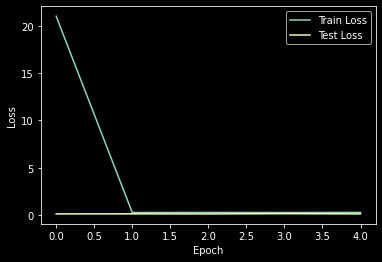

In [55]:
plt.plot(loss[0], label="Train Loss")
plt.plot(loss[1], label="Test Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend();

In [17]:
start_time = time.time()

y_pred = trained_model(x_train)

prediction = y_pred.detach().numpy()

print("Time: %s seconds" % (time.time() - start_time))

data_train.head()

prediction[0]

Time: 0.9332220554351807 seconds


array([nan], dtype=float32)

In [14]:
# data_train.to_csv('hybrid_nn_dqc_train.csv', index=False)
# data_test.to_csv('hybrid_nn_dqc_test.csv', index=False)

In [15]:
loss_data = pd.DataFrame()
loss_data['train_loss'] = loss[0]
loss_data['test_loss'] = loss[1]
loss_data.to_csv('hybrid_nn_dqc_loss.csv', index=False)
loss_data.head()

,train_loss,test_loss
0,0.128954,0.005775
1,0.002195,0.000219
2,0.000318,0.000078
3,0.000146,0.000043
4,0.000083,0.000025


### Plots

In [19]:
def plot_stock_prices(data_train, data_test, title='train'):
    
    data_train = data_train.sort_values('initial_stock_price')
    data_test = data_test.sort_values('initial_stock_price')
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].scatter(data_train['initial_stock_price'], data_train['option_price'], s=4, c='b', 
                label='Monte-Carlo')
    axs[0].scatter(data_train['initial_stock_price'], data_train['predicted_option_price'], s=4, c='r',
                label='Model')
    axs[0].set_title('Train')
    axs[1].scatter(data_test['initial_stock_price'], data_test['option_price'], s=4, c='b', 
                label='Monte-Carlo')
    axs[1].scatter(data_test['initial_stock_price'], data_test['predicted_option_price'], s=4, c='r',
                label='Model')
    axs[1].set_title('Test')
    for ax in axs.flat:
        ax.set(xlabel='initial stock price', ylabel='option price')
        ax.label_outer()
    plt.savefig(title+'.png', facecolor='white', dpi=150)

    
def plot_loss(loss, title='train'):
    
    train_loss, test_loss = loss[0], loss[1]
    epochs = [i for i in range(len(train_loss))]
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].plot(epochs, train_loss, c='b')
    axs[0].set_title('Train')
    axs[1].plot(epochs, test_loss, c='b')
    axs[1].set_title('Test')
    for ax in axs.flat:
        ax.set(xlabel='epoch', ylabel='loss')
        ax.label_outer()
    plt.savefig(title+'.png', facecolor='white', dpi=150)

In [22]:
# plot_loss(loss, 'hybrid_nn_dqc_loss')

In [23]:
# plot_stock_prices(data_train, data_test, title='hybrid_nn_dqc')